## Combining different types of geographic data for insight

#### Setup

We'll be using a new python library called [geopandas](https://geopandas.org/en/stable/) to read datasets with geographic information.

We are importing folium and matplotlib (libraries we've used in previous data viz lessons) because we can also use these libraries to visualize multiple types of geographic data (i.e. both polygons and points).

In [ ]:
# import necessary libraries

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot as gplt
import folium

## Loading datasets
We'll be visualizing data from two different Iran Open Data portals. The first dataset is a geographic dataset on [higher education institutes](https://raw.githubusercontent.com/kwonjs/datasets-to-use/main/iranopendata-university-dataset.geojson). The second dataset is on [employment/economic data](https://raw.githubusercontent.com/kwonjs/datasets-to-use/main/sciehe1735en.csv
) in Iran. You can **directly download** them by clicking on the hyperlinks.

You can also **read more** about the context here for the [employment](https://iranopendata.org/en/dataset/literate-employed-population-qualification-terms-gender-province-1394) and [education](https://irandataportal.syr.edu/colleges-and-universities) datasets by clicking on the hyperlinks.

Let's load the raw datasets into the jupyter notebook!

In [ ]:
# importing the datasets as datasets

# geojson file of higher education institutes (colleges and universities) in iran
# non-comprehensive list from iran open data (syracuse edu)
univ_url = "https://raw.githubusercontent.com/ICFJ-Computational-Journalism/datasets/main/csv/iranopendata-university-dataset.geojson"
universities = gpd.read_file(univ_url)

# geojson file of iran's provinces
province_url = "https://raw.githubusercontent.com/ICFJ-Computational-Journalism/datasets/main/csv/iran-provinces.geojson"
provinces = gpd.read_file(province_url)

# csv of employment and economic participation by province
employment_url = "https://raw.githubusercontent.com/ICFJ-Computational-Journalism/datasets/main/csv/sciehe1735en.csv"
employment = pd.read_csv(employment_url)

And then let's take a quick look at the datasets we'll be working with.

In [ ]:
# seeing the first five rows of the employment data

employment.head(5)

,Gender and province,Economic participation rate (All country) - percent,Employment rate (All country) - percent,Population rate of underemployment (All country) - percent,The unemployment rate (All country) - percent,Employment ratio (All country) - percent,Proportion of the population with underemployment (All country) - percent,The share of workers with normal working hours to 49 hours and more (All country) - percent,The underemployment rate (All country) - percent,The share of employment in agriculture (All country) - percent,...,The unemployment rate (Rural areas) - percent,Employment ratio (Rural areas) - percent,Proportion of the population with underemployment (Rural areas) - percent,The share of workers with normal working hours to 49 hours and more (Rural areas) - percent,The underemployment rate (Rural areas) - percent,The share of employment in agriculture (Rural areas) - percent,The share of employment in industry (Rural areas) - percent,The share of employment in the service sector (Rural areas) - percent,The share of employment in the private sector (Rural areas) - percent,The share of employment in the public sector (Rural areas) - percent
0,Male and Female,37.4,87.90,7.8,12.1,32.9,8.9,40.4,3.3,19.4,...,8.2,36.7,11.9,36.9,4.6,50.9,27.2,21.9,94.1,5.9
1,Azerbaijan East (Male and Female),40.4,87.60,7.2,12.4,35.4,8.2,34.5,3.4,21.8,...,4.6,41.7,6.4,38.6,3.1,51.9,30.5,17.6,96.3,3.7
2,Azerbaijan West (Male and Female),42.7,89.00,7.0,11.0,38.0,7.9,40.4,3.3,39.3,...,5.9,48.5,6.5,35.8,2.9,69.6,17.7,12.7,97.1,2.9
3,Ardabil (Male and Female),42.4,7.86,7.0,13.3,36.8,8.1,44.8,3.4,35.0,...,7.4,46.0,7.5,41.9,3.5,69.4,16.5,14.1,97.1,2.9
4,Isfahan (Male and Female),39.7,86.30,10.6,13.7,34.3,12.3,31.6,5.6,11.4,...,8.4,40.7,18.2,31.5,8.8,37.7,36.6,25.6,93.7,6.3


In [ ]:
# seeing the first five rows of the university/college data

universities.head(5)

,university_type,university_name,additional_note,geometry
0,arts,University of Art (Tehran),,POINT (51.40614 35.70337)
1,arts,Shiraz University,,POINT (52.49396 29.64592)
2,arts,Tarbiat Modares University,,POINT (51.38369 35.72346)
3,arts,Sooreh Art University,,POINT (51.36993 35.70018)
4,law,Allame Tabataba’ee University (ATU),,POINT (51.26030 35.75949)


In [ ]:
# seeing the first five rows of the provinces data

provinces.head(5)

,name,english_name,geometry
0,"استان البرز, ایران",Alborz,"POLYGON ((50.16315 35.61053, 50.16454 35.60331..."
1,"استان اردبیل, ایران",Ardabil,"POLYGON ((47.28717 38.30226, 47.29106 38.30031..."
2,"استان آذربایجان غربی, ایران",West Azarbaijan,"POLYGON ((44.03189 39.37173, 44.03205 39.37101..."
3,"استان آذربایجان شرقی, ایران",East Azarbaijan,"POLYGON ((45.09345 38.32197, 45.09352 38.32115..."
4,"استان بوشهر, ایران",Bushehr,"POLYGON ((49.58014 29.66744, 49.71026 29.53008..."


*Note: The university and college dataset contains point data while the province + employment data contains polygons / boundary data. The university/college dataset is **not comprehensive** but works for the purpose of this lesson.*

## Cleaning and preparing the data to be visualized

The employment dataset is organized by gender and **province name**. We can connect the geojson data (containing each province and the geographic coordinates making up its boundary) with the employment dataset by **province name** (contained in the "english_name" column).

In order to connect these two datasets, we'll first need to make sure that the province names in the columns in either dataset are **the same** so that we can join the two datasets. One contains the actual polygon data for each province needed to visualize on a map and the other contains employment data tied to each province.

Let's first split the "Gender and province" column in the employment dataframe into two columns, one for gender and one for province. We can then isolate the province column so we can match that province column to the "english_name" (i.e. English province name) column in the provinces dataframe.

The general format of the "Gender and province" column seems to be **[Province name] (Gender)**. Let's first split the column then by the left parenthesis, or '('.

In [ ]:
# Splitting up the "Gender and province" column by the left parenthesis
gender_province_cols1 = employment["Gender and province"].str.split('(', expand=True)

Column '0' (the first column) is almost all provinces (except the first column, which has 'Male and Female,' but we can fix this later). Let's isolate this column and call it 'isolated_province_col'.

In [ ]:
isolated_provinces_col = gender_province_cols1[0] # the '0' index selects for the first column in this separate dataframe
isolated_provinces_col

0      Male and Female
1     Azerbaijan East 
2     Azerbaijan West 
3             Ardabil 
4             Isfahan 
            ...       
91         Mazandaran 
92            Markazi 
93          Hormozgan 
94            Hamadan 
95               Yazd 
Name: 0, Length: 96, dtype: object

We split the original column, but the split wasn't perfect. There is still a hanging right parenthesis (or ')' ) in the newly made second column (which is supposed to contain gender). Let's split that column as well so that we get rid of that hanging right parenthesis.

In [ ]:
# Splitting up the newly made 'gender' column (or the second column) by the right parenthesis as well
# Then assign the first column to 'isolated_gender_col,' since we've now successfully gotten a mostly clean gender column
isolated_gender_col = gender_province_cols1[1].str.split(')', expand=True)[0]
isolated_gender_col

0                None
1     Male and Female
2     Male and Female
3     Male and Female
4     Male and Female
           ...       
91             Female
92             Female
93             Female
94             Female
95             Female
Name: 0, Length: 96, dtype: object

Now let's add these isolated, mostly clean columns back to the employment dataframe.

In [ ]:
employment["province"] = isolated_provinces_col # adds this column to the employment dataset and calls this column "Province"
employment["gender"] = isolated_gender_col # adds this column to the employment dataset and calls this column "Gender"

# Let's load in the first five rows of the employment dataframe to check that we successfully added these new columns into the dataframe
#employment.head(5) # to check

Now we need to match the newly created "Province" column in the employment dataframe to column "english_name" in the provinces dataframe.

Let's compare the different province names in the  "english_name" and "Province" columns.

In [ ]:
# Get unique values in "english_name"
# Get unique values in "Province"
# If they don't match - change a value in one column to match the other
provinces["english_name"].unique()
# employment[["Province", "Gender"]]

array(['Alborz', 'Ardabil', 'West Azarbaijan', 'East Azarbaijan',
       'Bushehr', 'Chaharmahal and Bakhtiari', 'Fars', 'Gilan',
       'Golestan', 'Hamadan', 'Hormozgan', 'Ilam', 'Isfahan', 'Kerman',
       'Kermanshah', 'Razavi Khorasan', 'South Khorasan',
       'North Khorasan', 'Khuzestan', 'Kohgiluyeh and Boyer Ahmad',
       'Kurdistan', 'Lorestan', 'Markazi', 'Mazandaran', 'Qazvin', 'Qom',
       'Semnan', 'Sistan and Baluchestan', 'Tehran', 'Yazd', 'Zanjan'],
      dtype=object)

In [ ]:
employment["province"].unique()

array(['Male and Female', 'Azerbaijan East ', 'Azerbaijan West ',
       'Ardabil ', 'Isfahan ', 'Alborz ', 'Ilam ', 'Bushehr ', 'Tehran ',
       'Chahar Mahaal and Bakhtiari ', 'Khorasan South ',
       'Khorasan Razavi ', 'Khorasan North ', 'Khuzestan ', 'Zanjan ',
       'Semnan ', 'Sistan and Baluchestan ', 'Fars ', 'Qazvin ', 'Qom ',
       'Kurdistan ', 'Kerman ', 'Kermanshah ',
       'Kohgiluyeh and Boyer-Ahmad ', 'Golestan ', 'Gilan ', 'Lorestan ',
       'Mazandaran ', 'Markazi ', 'Hormozgan ', 'Hamadan ', 'Yazd ',
       'Male', 'Female'], dtype=object)

In [ ]:
differences = list(set(provinces["english_name"]).difference(employment["province"]))
differences

['Markazi',
 'Bushehr',
 'Sistan and Baluchestan',
 'Yazd',
 'East Azarbaijan',
 'Semnan',
 'Chaharmahal and Bakhtiari',
 'West Azarbaijan',
 'Khuzestan',
 'Lorestan',
 'Ilam',
 'South Khorasan',
 'Kerman',
 'Kermanshah',
 'Qom',
 'Gilan',
 'Qazvin',
 'North Khorasan',
 'Fars',
 'Ardabil',
 'Hamadan',
 'Alborz',
 'Isfahan',
 'Kohgiluyeh and Boyer Ahmad',
 'Kurdistan',
 'Zanjan',
 'Hormozgan',
 'Razavi Khorasan',
 'Golestan',
 'Mazandaran',
 'Tehran']

Let's rename the differing province names in the employment dataset. (Many of them are only differing by a 'space' that was left when we split the "Gender and province" column)

In [ ]:
employment = employment.replace({'province' : {
    'Mazandaran ' : 'Mazandaran',
    'Khorasan Razavi ' : 'Razavi Khorasan',
    'Kermanshah ' : 'Kermanshah',
    'Yazd ' : 'Yazd',
    'Isfahan ' : 'Isfahan',
    'Kurdistan ' : 'Kurdistan',
    'Gilan ' : 'Gilan',
    'Khuzestan ' : 'Khuzestan',
    'Khorasan South ' : 'South Khorasan',
    'Markazi ' : 'Markazi',
    'Sistan and Baluchestan ' : 'Sistan and Baluchestan',
    'Golestan ' : 'Golestan',
    'Ilam ' : 'Ilam',
    'Bushehr ' : 'Bushehr',
    'Qazvin ' : 'Qazvin',
    'Kohgiluyeh and Boyer-Ahmad ' : 'Kohgiluyeh and Boyer Ahmad',
    'Zanjan ' : 'Zanjan',
    'Tehran ' : 'Tehran',
    'Qom ' : 'Qom',
    'Lorestan ' : 'Lorestan',
    'Fars ' : 'Fars',
    'Kerman ' : 'Kerman',
    'Khorasan North ' : 'North Khorasan',
    'Azerbaijan East ' : 'East Azarbaijan',
    'Ardabil ' : 'Ardabil',
    'Hamadan ' : 'Hamadan',
    'Hormozgan ' : 'Hormozgan',
    'Azerbaijan West ' : 'West Azarbaijan',
    'Alborz ' : 'Alborz',
    'Semnan ' : 'Semnan',
    'Chahar Mahaal and Bakhtiari ' : 'Chaharmahal and Bakhtiari'
    }})

Now that the province names are the same for both the employment and province dataframes, let's merge the two datasets together.

First, let's rename the column "english_name" to the same column name, "Province", in the employment dataset.

In [ ]:
provinces = provinces.rename(columns={'english_name': 'province'})

In [ ]:
employment_province = provinces.merge(employment, on='province', how='left')
employment_province

,name,province,geometry,Gender and province,Economic participation rate (All country) - percent,Employment rate (All country) - percent,Population rate of underemployment (All country) - percent,The unemployment rate (All country) - percent,Employment ratio (All country) - percent,Proportion of the population with underemployment (All country) - percent,...,Employment ratio (Rural areas) - percent,Proportion of the population with underemployment (Rural areas) - percent,The share of workers with normal working hours to 49 hours and more (Rural areas) - percent,The underemployment rate (Rural areas) - percent,The share of employment in agriculture (Rural areas) - percent,The share of employment in industry (Rural areas) - percent,The share of employment in the service sector (Rural areas) - percent,The share of employment in the private sector (Rural areas) - percent,The share of employment in the public sector (Rural areas) - percent,gender
0,"استان البرز, ایران",Alborz,"POLYGON ((50.16315 35.61053, 50.16454 35.60331...",Alborz (Male and Female),36.9,85.10,4.1,14.9,31.4,4.8,...,31.3,5.5,53.8,2.1,21.1,40.3,38.7,83.6,16.4,Male and Female
1,"استان البرز, ایران",Alborz,"POLYGON ((50.16315 35.61053, 50.16454 35.60331...",Alborz (Male),62.3,87.70,4.5,12.3,54.7,5.1,...,54.9,5.8,56.5,2.2,20.9,42.3,36.8,84.6,15.4,Male
2,"استان البرز, ایران",Alborz,"POLYGON ((50.16315 35.61053, 50.16454 35.60331...",Alborz (Female),10.6,69.20,1.6,30.8,7.3,2.4,...,5.9,2.6,26.4,1.2,22.9,20.1,57.0,73.2,26.8,Female
3,"استان اردبیل, ایران",Ardabil,"POLYGON ((47.28717 38.30226, 47.29106 38.30031...",Ardabil (Male and Female),42.4,7.86,7.0,13.3,36.8,8.1,...,46.0,7.5,41.9,3.5,69.4,16.5,14.1,97.1,2.9,Male and Female
4,"استان اردبیل, ایران",Ardabil,"POLYGON ((47.28717 38.30226, 47.29106 38.30031...",Ardabil (Male),65.9,87.80,8.1,12.2,57.8,9.2,...,65.9,9.9,54.6,4.1,62.4,19.4,18.1,96.4,3.6,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"استان یزد, ایران",Yazd,"POLYGON ((52.80050 31.49321, 52.80161 31.49154...",Yazd (Male),57.6,90.80,3.0,9.2,52.3,3.3,...,59.4,4.6,21.3,1.7,37.2,35.7,27.1,89.7,10.3,Male
89,"استان یزد, ایران",Yazd,"POLYGON ((52.80050 31.49321, 52.80161 31.49154...",Yazd (Female),11.5,84.40,1.3,15.6,9.7,1.6,...,14.9,2.2,7.0,1.5,33.2,46.2,20.5,89.0,11.0,Female
90,"استان زنجان, ایران",Zanjan,"POLYGON ((47.17412 36.79167, 47.17440 36.79139...",Zanjan (Male and Female),42.1,88.80,4.2,11.2,37.4,7.4,...,45.1,4.0,41.3,1.8,63.5,23.7,12.8,94.9,5.1,Male and Female
91,"استان زنجان, ایران",Zanjan,"POLYGON ((47.17412 36.79167, 47.17440 36.79139...",Zanjan (Male),64.9,90.50,5.1,9.5,58.8,5.6,...,66.2,5.4,53.5,2.2,58.9,25.7,15.5,94.1,5.9,Male


Now the geographic boundaries associated with each province is tied to employment-related data as well.


Notice that multiple types of data are tied to the same province - each province has female-only ("Female" value in the "Gender" column in employment_province dataframe), male-only ("Male") and male and female ("Male and Female") gender data related to under and unemployment rates. Let's geographically visualize specifically "Male and Female" data.

In [ ]:
employment_province_mf = employment_province[(employment_province["gender"] == "Male and Female")]

Let's now map this filtered geographic employment data with the university/college location data using folium (which we've imported at the beginning of this lesson) and [`folium.Map()`](https://python-visualization.github.io/folium/modules.html#module-folium.map).

In [ ]:
# Creating a map object in Folium
# Setting the latitude and longitude (in this case, the center of Iran)
m = folium.Map(location=[32.4279, 53.6880], zoom_start=5.25)
m

Now let's filter for only the provincial data where both male and female genders are included. In other words, the "Gender" column should only contain "Male and Female" data.

In [ ]:
employment_mf = employment[employment["gender"] == "Male and Female"]

Let's rename the column "english_name" to the same column name, "Province", as the one in the employment dataset. This will help us tie these two datasets, one with data to draw province boundaries and one with employment data to visualize in a Folium map.



In [ ]:
provinces = provinces.rename(columns={'english_name': 'province'})

Now let's convert the provinces dataset to a GeoJSON to be able to be used with the Folium library.

In [ ]:
provinces_gdf = gpd.GeoDataFrame(provinces, geometry="geometry")
provinces_gdf.to_file("provinces.geojson", driver="GeoJSON")

provinces = gpd.read_file("provinces.geojson")

In [ ]:
employment_province_mf

,name,province,geometry,Gender and province,Economic participation rate (All country) - percent,Employment rate (All country) - percent,Population rate of underemployment (All country) - percent,The unemployment rate (All country) - percent,Employment ratio (All country) - percent,Proportion of the population with underemployment (All country) - percent,...,Employment ratio (Rural areas) - percent,Proportion of the population with underemployment (Rural areas) - percent,The share of workers with normal working hours to 49 hours and more (Rural areas) - percent,The underemployment rate (Rural areas) - percent,The share of employment in agriculture (Rural areas) - percent,The share of employment in industry (Rural areas) - percent,The share of employment in the service sector (Rural areas) - percent,The share of employment in the private sector (Rural areas) - percent,The share of employment in the public sector (Rural areas) - percent,gender
0,"استان البرز, ایران",Alborz,"POLYGON ((50.16315 35.61053, 50.16454 35.60331...",Alborz (Male and Female),36.9,85.10,4.1,14.9,31.4,4.8,...,31.3,5.5,53.8,2.1,21.1,40.3,38.7,83.6,16.4,Male and Female
3,"استان اردبیل, ایران",Ardabil,"POLYGON ((47.28717 38.30226, 47.29106 38.30031...",Ardabil (Male and Female),42.4,7.86,7.0,13.3,36.8,8.1,...,46.0,7.5,41.9,3.5,69.4,16.5,14.1,97.1,2.9,Male and Female
6,"استان آذربایجان غربی, ایران",West Azarbaijan,"POLYGON ((44.03189 39.37173, 44.03205 39.37101...",Azerbaijan West (Male and Female),42.7,89.00,7.0,11.0,38.0,7.9,...,48.5,6.5,35.8,2.9,69.6,17.7,12.7,97.1,2.9,Male and Female
9,"استان آذربایجان شرقی, ایران",East Azarbaijan,"POLYGON ((45.09345 38.32197, 45.09352 38.32115...",Azerbaijan East (Male and Female),40.4,87.60,7.2,12.4,35.4,8.2,...,41.7,6.4,38.6,3.1,51.9,30.5,17.6,96.3,3.7,Male and Female
12,"استان بوشهر, ایران",Bushehr,"POLYGON ((49.58014 29.66744, 49.71026 29.53008...",Bushehr (Male and Female),35.1,88.40,5.9,11.6,31.0,6.7,...,31.7,6.3,45.8,2.3,37.3,21.9,40.8,86.8,13.2,Male and Female
15,"استان چهارمحال و بختیاری, ایران",Chaharmahal and Bakhtiari,"POLYGON ((49.50008 32.70309, 49.50057 32.70295...",Chahar Mahaal and Bakhtiari (Male and Female),36.4,89.20,4.9,10.8,32.5,5.5,...,32.9,6.3,53.0,2.1,27.1,50.2,22.7,91.5,8.5,Male and Female
18,"استان فارس, ایران",Fars,"POLYGON ((50.60318 29.94373, 50.60457 29.94373...",Fars (Male and Female),36.5,83.30,9.9,16.7,30.4,11.8,...,31.9,14.9,36.3,4.9,49.5,26.4,24.1,94.4,5.6,Male and Female
21,"استان گیلان, ایران",Gilan,"POLYGON ((48.56918 38.41421, 48.56945 38.41255...",Gilan (Male and Female),40.3,84.50,5.1,15.5,34.0,6.0,...,38.1,6.3,56.6,2.3,48.3,23.0,28.7,94.8,5.2,Male and Female
24,"استان گلستان, ایران",Golestan,"POLYGON ((53.85267 36.98444, 53.85480 36.93910...",Golestan (Male and Female),36.5,91.10,18.0,8.9,33.2,19.7,...,35.6,23.9,30.8,8.2,43.0,33.7,23.3,94.6,5.4,Male and Female
27,"استان همدان, ایران",Hamadan,"POLYGON ((47.79719 34.85116, 47.80165 34.84272...",Hamadan (Male and Female),38.3,90.40,5.2,9.6,34.6,5.8,...,40.6,6.0,46.7,2.1,52.8,27.1,20.0,93.8,6.2,Male and Female


## Mapping with geopandas

Let's now map this filtered geographic employment data with the university/college location data.

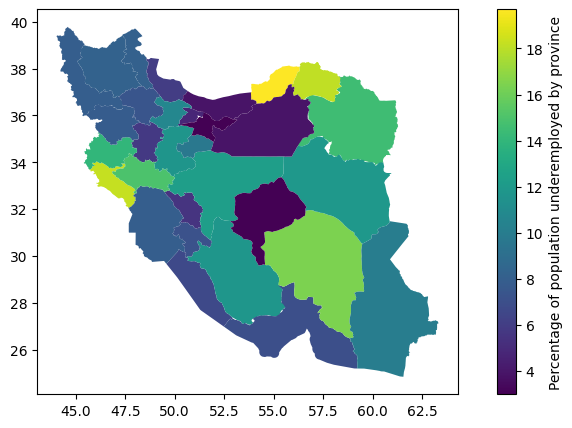

In [ ]:
# Plotting a simple choropleth map with geopandas
choro = employment_province_mf.plot(column = 'Proportion of the population with underemployment (All country) - percent', # Data column to visualize
                            legend = True, # It's good practice to show a legend
                            figsize = [10,5], # Set chart dimensions
                            legend_kwds = {'label': "Percentage of population underemployed by province"}) # Adding a label title to describe what data you're visualizing

# The axes in this case represent latitude and longitude

Now let's try plotting both the choropleth map (with shade representing the percentage of the population that is underemployed, by province) *and* the points showing the locations of higher education institutes across Iran.

Text(54.597222222222214, 0.5, 'Latitude')

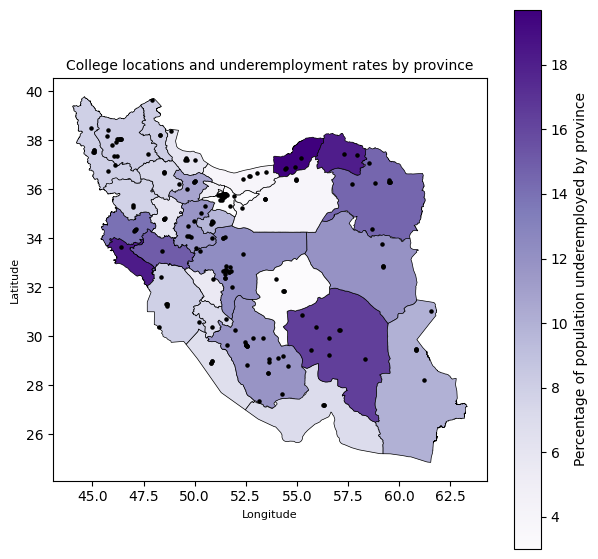

In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) # Since we're visualizing more than one type of data

# First, we plot the choropleth map showing the underemployment percentages by province
# The lighter the shade of purple, the lower the underemployment percentage
employment_province_mf.plot(ax=ax,
                      column='Proportion of the population with underemployment (All country) - percent', # Data column to visualize
                      legend=True,
                      edgecolor='black',
                      linewidth=0.5,
                      cmap="Purples",
                      legend_kwds = {'label': "Percentage of population underemployed by province"})

# Then, on top of the choropleth map we just made, we plot the points showing where colleges and universities are
# Each black point represents one college or university
universities.plot(ax=ax,
                  color='black',
                  markersize=5)

ax.set_title('College locations and underemployment rates by province', fontsize=10)
ax.set_xlabel('Longitude', fontsize=8)
ax.set_ylabel('Latitude', fontsize=8)

We've just created static maps - but we can add some interactivity using `geopandas.explore()`. This should return a Folium map where you can hover to see which province you're looking at and what data points are associated with that province.

The employment dataset has many variables/columns, so adding the parameter 'tooltip' within `explore()` allows you to narrow down which variables/columns you specifically want to focus on.

In [ ]:
employment_province_mf.explore(
    column='Proportion of the population with underemployment (All country) - percent',
    cmap='Purples',
    tooltip=['province', 'Proportion of the population with underemployment (All country) - percent'] # the specific columns to highlight in the tooltip
)

In [ ]:
from IPython.display import display

In [ ]:
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# Now we can create a choropleth map with these two datasets

folium.Choropleth(geo_data = provinces, # geo_data refers to your geojson file (with data used to draw geographic boundaries)
    name = "choropleth",
    data = employment_mf, # data refers to the non-geographic data you're trying to tie to geographic data
    columns = ["province", "Employment rate (All country) - percent"], # what data are you wanting to visualize?
    key_on = "feature.properties.province", # what column ties both datasets? in this case, it's the name of the province, or the "Province" column (this is why it's important that both columns have the same name)
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.5,
    legend_name = 'Employment rate (percent)').add_to(m)

folium.LayerControl().add_to(m)
m # call the the map again after adding this data!

ValueError: key_on `'properties.Province'` not found in GeoJSON.

This isn't the best choropleth map — as you can see, most provinces are colored the same shade as red, since employment rates across most provinces are in the 80 percent range, which is the upper range of our legend displayed above the map. This particular column we're displaying, "Employment rate (All country) - percent", may not be the best variable to visualize using a choropleth map. We might choose a different variable with data points scattered across a range, such as the map we created earlier using `explore()` to visualize the proportion of each province's population that experiences underemployment.

## Resources for mapping with python

We’ve done a lot! You can do a lot of variations of what we’ve done here with choropleths and point maps. Here are some more resources if you want to dig in deeper.

* [Three ways to map with Python](https://medium.com/geekculture/three-ways-to-plot-choropleth-map-using-python-f53799a3e623)

#### Matplotlib-specific
* [Choosing color schemes](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for choropleth maps

#### Geopandas-specific

* [Creating geopandas from pandas](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html)
* [Plotting maps with geopandas](https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73)